# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [34]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

#### Use Quandl api to get BTC/USD data from kraken exchange

In [2]:
#import quandl
#data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

#### Read data set

In [3]:
data1 = pd.read_csv(filepath_or_buffer="bitcoin_price.csv")
data2 = pd.read_csv(filepath_or_buffer="sentiment.txt")

#### View data info

In [4]:
data1.columns = ['stamp', 'price']
data1.info()
data1 = data1[:-2]
data1.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814 entries, 0 to 2813
Data columns (total 2 columns):
stamp    2814 non-null object
price    2812 non-null float64
dtypes: float64(1), object(1)
memory usage: 44.0+ KB


,stamp,price
2807,3/25/18 0:00,8449.83
2808,3/26/18 0:00,8138.34
2809,3/27/18 0:00,7790.16
2810,3/28/18 0:00,7937.20
2811,3/29/18 1:14,7956.15


In [5]:
data2.columns = ['stamp', 'sentiment']
data2.head(5)

,stamp,sentiment
0,20180327,0.256778
1,20180326,0.256778
2,20180325,0.256778
3,20180324,0.256778
4,20180323,0.256778


In [6]:
data2.info()
data2.dropna(axis=1,how='any',inplace=True)
data2.stamp.dtype
#data2['sentiment'] = data2.sentiment.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 2 columns):
stamp        1053 non-null int64
sentiment    1053 non-null float64
dtypes: float64(1), int64(1)
memory usage: 16.5 KB


dtype('int64')

#### View data rows

In [7]:
def conv_time(t1):
    month = t1.split('/')[0]
    day = t1.split('/')[1]
    year = '20' + t1.split('/')[2].split()[0]

    if len(month) < 2:
        month = "0" + month
    day_string = str(day)

    if len(day) < 2:
        day = "0" + day

    return(int(year + month + day))

In [8]:
data1.stamp = data1.stamp.apply(conv_time)
data1.head()

,stamp,price
0,20100718,0.09
1,20100719,0.08
2,20100720,0.07
3,20100721,0.08
4,20100722,0.05


#### Join on data frame

In [9]:
data = pd.merge(data1,data2, on='stamp', how='inner')
data.head(5)

,stamp,price,sentiment
0,20150510,239.63,0.270581
1,20150511,241.85,0.226697
2,20150512,240.99,0.272751
3,20150513,235.80,0.227079
4,20150514,236.74,0.266517


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1053 entries, 0 to 1052
Data columns (total 3 columns):
stamp        1053 non-null int64
price        1053 non-null float64
sentiment    1053 non-null float64
dtypes: float64(2), int64(1)
memory usage: 32.9 KB


In [11]:
data.describe(include='all')

,stamp,price,sentiment
count,1.053000e+03,1053.000000,1053.000000
mean,2.016354e+07,2511.925783,0.249166
std,8.903517e+03,3809.823010,0.101279
min,2.015051e+07,209.130000,-0.792335
25%,2.016013e+07,415.560000,0.197885
50%,2.016102e+07,681.630000,0.256778
75%,2.017071e+07,2641.660000,0.312855
max,2.018033e+07,19343.040000,0.464080


In [12]:
data['stamp'] = pd.to_datetime(data['stamp'].apply(str),format='%Y%m%d')
data = data.sort_values(by='stamp')
data.head()

,stamp,price,sentiment
0,2015-05-10,239.63,0.270581
1,2015-05-11,241.85,0.226697
2,2015-05-12,240.99,0.272751
3,2015-05-13,235.80,0.227079
4,2015-05-14,236.74,0.266517


#### Plot line graph base on `Weighted Price`

In [13]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [14]:
from sklearn.preprocessing import MinMaxScaler
values = data['price'].values.reshape(-1,1)
sentiment = data['sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = sentiment.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


#### Split 70% of data for training and 30% for testing

In [15]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

737 316


#### Create function for creating dataset with look back

In [16]:
#Look back means to use today's sentiment to predict tomorrow's price
def create_dataset(dataset, look_back, sentiment):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        np.append(a,sentiment[i])
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [17]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

736
315


In [18]:
trainX.shape

(736, 1)

#### Reshape X for model training

In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [28]:
trainX

array([[[0.00159403]],

       [[0.00171005]],

       [[0.00166511]],

       [[0.00139386]],

       [[0.00144299]],

       [[0.00147278]],

       [[0.0013902 ]],

       [[0.00140954]],

       [[0.00124073]],

       [[0.00119212]],

       [[0.00131285]],

       [[0.00136773]],

       [[0.00164054]],

       [[0.00156267]],

       [[0.00167556]],

       [[0.00148219]],

       [[0.00147382]],

       [[0.00146598]],

       [[0.00148114]],

       [[0.0014618 ]],

       [[0.00126268]],

       [[0.00109073]],

       [[0.00074109]],

       [[0.00086861]],

       [[0.00086339]],

       [[0.00079649]],

       [[0.00083151]],

       [[0.00086496]],

       [[0.00074527]],

       [[0.00102018]],

       [[0.00105572]],

       [[0.00103586]],

       [[0.00109178]],

       [[0.00110119]],

       [[0.00123446]],

       [[0.00129195]],

       [[0.00147278]],

       [[0.00218304]],

       [[0.00209262]],

       [[0.00207694]],

       [[0.0017989 ]],

       [[0.00188

In [37]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss = 'mse', optimizer='rmsprop')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)


In [131]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

#### Plot line graph to show amount loss according the the epoch

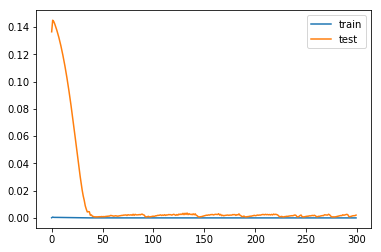

In [38]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### See training set prediction

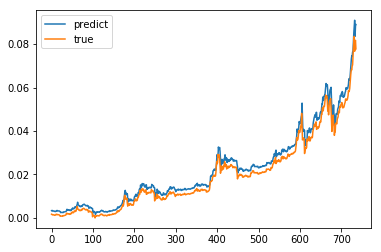

In [39]:
yhat = model.predict(trainX)
pyplot.plot(yhat, label='predict')
pyplot.plot(trainY, label='true')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

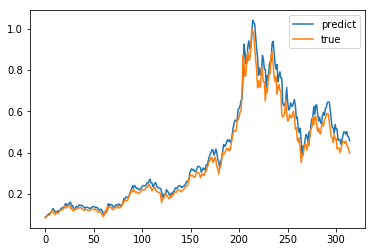

In [40]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [41]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### RMSE

In [42]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 871.068


#### Plot line graph with Y as USD

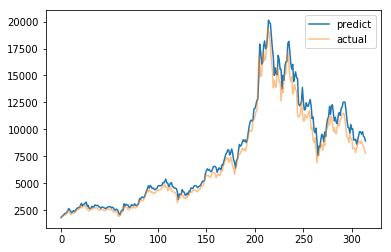

In [43]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [44]:
predictDates = data.tail(len(testX)).stamp

#### Reshape testY and yhat for plotly

In [45]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [46]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

## The prediction accuracy of Rise/Down

In [47]:
def acu_bin(a1):
    t1 = np.zeros(len(a1) - 1)
    for i in range(len(t1)):
        t1[i] = np.sign(a1[i+1] - a1[i])
    return t1
    

In [48]:
yhat = model.predict(testX)
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
#y
yhat_bin = acu_bin(yhat)
testY_bin = acu_bin(testY)
print("The prediction accuracy is : ", np.mean(yhat_bin == testY_bin))
from sklearn.metrics import confusion_matrix
confusion_matrix(testY_bin, yhat_bin)

The prediction accuracy is :  0.5382165605095541


array([[73, 73],
       [72, 96]])

### Using additional features for model training

#### Find corrleration in features to `Weighted Price`

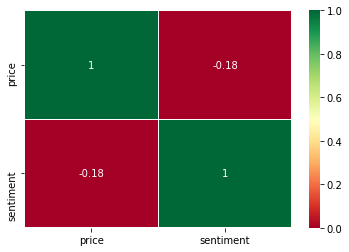

In [49]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`. 
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`

#### Function to convert series to supervised learning

In [104]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Get all data values

In [105]:
values = data[['price']].values
values = values.astype('float32')

#### Normalize features to range from 0 to 1

In [106]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Frame as supervised learning

In [107]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var1(t)
1,0.001594,0.001710
2,0.001710,0.001665
3,0.001665,0.001394
4,0.001394,0.001443
5,0.001443,0.001473


#### Drop unncessary columns 

In [108]:
#reframed.drop(reframed.columns[[1,3]], axis=1, inplace=True)
#print(reframed.head())

#### Split data to 70% training, 30% testing

In [109]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(736, 1, 1) (736,) (316, 1, 1) (316,)


#### Training the LSTM model with 300 epochs

In [110]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

#### Plot line graph to show amount loss according the the epoch

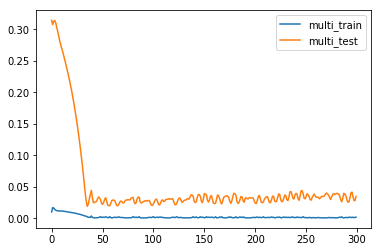

In [111]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

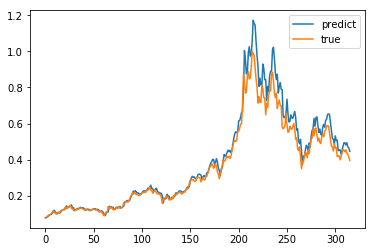

In [112]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [113]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE

In [114]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1117.548


#### Plot line graph with actual price, predicted price with feature `Weighted Price`, predicted price with features `Volume` and `Weighted Price`

In [115]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

- LSTM with single feature of `Weighted Price` have RMSE of 159.194
- LSTM with features of `Volume(BTC)`, `Volume(Currency)` and `Weighted Price` have RMSE of 96.184
- LSTM with multi features shows more accurate results as show in line chart above